<a href="https://colab.research.google.com/github/Fiendi/Data-Augmentation-with-K-NN/blob/main/KNN_TUBES_SLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive


MyDrive


   K     Metric  Accuracy Mean  Accuracy Std
0  3  euclidean       0.761875      0.027266
1  3  manhattan       0.765000      0.020965
2  3     cosine       0.459750      0.011770
3  5  euclidean       0.772000      0.026755
4  5  manhattan       0.774625      0.027216
5  5     cosine       0.480875      0.005457
6  7  euclidean       0.770125      0.027688
7  7  manhattan       0.775750      0.032274
8  7     cosine       0.490500      0.011887
Best parameters - K: 7, Metric: manhattan, Best Accuracy: 0.77575


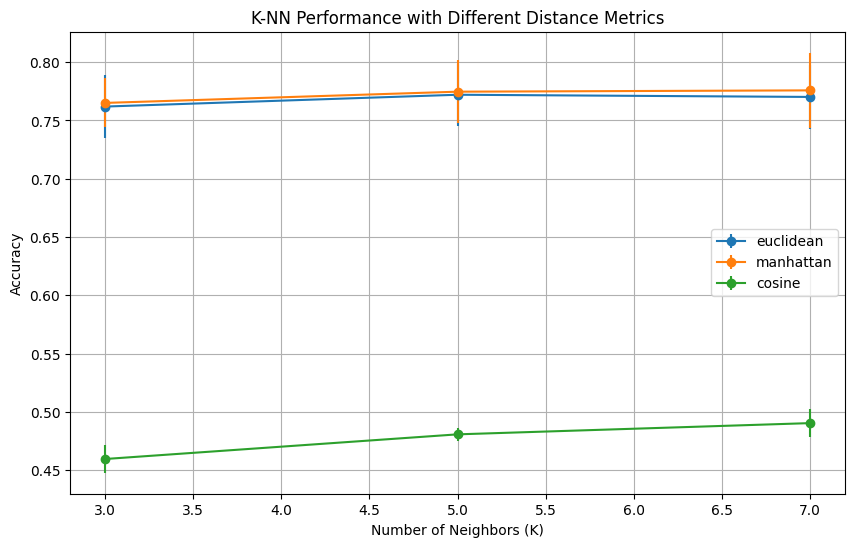

In [5]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Function to calculate waveform length
def waveform_length(epoch):
    return np.sum(np.abs(np.diff(epoch)))

# Function to calculate interquartile range
def interquartile_range(epoch):
    return np.percentile(epoch, 75) - np.percentile(epoch, 25)

# Function to calculate standard deviation
def standard_deviation(epoch):
    return np.std(epoch)

# Path to the datasets folder in Google Drive
base_path = '/content/drive/MyDrive/DATASET/'

# Load data
def load_data(directory):
    data = []
    for filename in glob.glob(os.path.join(directory, '*.txt')):
        with open(filename, 'r', encoding='utf-8') as file:
            data.append(file.read())
    return data

sets = ['SET A', 'SET B', 'SET C', 'SET D', 'SET E']
data = {s: load_data(os.path.join(base_path, s)) for s in sets}

# Combine data into a single DataFrame
all_data = []
labels = []
for label, s in enumerate(sets):
    for doc in data[s]:
        all_data.append(doc)
        labels.append(label)

df = pd.DataFrame({'EEG_Signal': all_data, 'Label': labels})

# Data Preprocessing: Cleaning and dividing into epochs
def clean_and_epoch(signal, epoch_length=200):
    # Split signal into individual numerical values
    signal_values = np.array(signal.split(), dtype=float)

    # Divide into epochs of specified length
    epochs = [signal_values[i:i + epoch_length] for i in range(0, len(signal_values), epoch_length)]
    return epochs

df['Epochs'] = df['EEG_Signal'].apply(clean_and_epoch)

# Feature Extraction
def extract_features(epochs):
    features = []
    for epoch in epochs:
        if len(epoch) == 200:
            wl = waveform_length(epoch)
            iqr = interquartile_range(epoch)
            std = standard_deviation(epoch)
            features.append([wl, iqr, std])
    return features

df['Features'] = df['Epochs'].apply(extract_features)

# Flatten the DataFrame to have one row per epoch
features = []
labels = []
for idx, row in df.iterrows():
    for feature in row['Features']:
        features.append(feature)
        labels.append(row['Label'])

features_df = pd.DataFrame(features, columns=['Waveform_Length', 'IQR', 'Std'])
labels_df = pd.DataFrame(labels, columns=['Label'])

# Combine features and labels into a single DataFrame
final_df = pd.concat([features_df, labels_df], axis=1)

# Prepare data for K-NN
X = final_df.drop('Label', axis=1)
y = final_df['Label']

# Define K-NN parameters
k_values = [3, 5, 7]
distance_metrics = ['euclidean', 'manhattan', 'cosine']
best_score = 0

# DataFrame to store results
results = []

# K-NN implementation and evaluation with standard deviation
for k in k_values:
    for metric in distance_metrics:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)
        std_score = np.std(scores) # Standard deviation of accuracy
        results.append({'K': k, 'Metric': metric, 'Accuracy Mean': mean_score, 'Accuracy Std': std_score})
        if mean_score > best_score:
            best_score = mean_score
            best_params = (k, metric)

# Create DataFrame for results
results_df = pd.DataFrame(results)

# Display results as a table
print(results_df)

print(f'Best parameters - K: {best_params[0]}, Metric: {best_params[1]}, Best Accuracy: {best_score}')

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for metric in distance_metrics:
    subset = results_df[results_df['Metric'] == metric]
    plt.errorbar(subset['K'], subset['Accuracy Mean'], yerr=subset['Accuracy Std'], label=metric, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K-NN Performance with Different Distance Metrics')
plt.legend()
plt.grid(True)
plt.show()
